<a href="https://colab.research.google.com/github/SergSof/predict_8_channel/blob/main/%D0%A1%D1%82%D1%83%D0%BF%D0%BD%D0%B8_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_(GAN_pix2pix)_40_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9%2C_8_%D0%BA%D0%B0%D0%BD%D0%B0%D0%BB%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TRAIN GAN**
---
**Задача**:  Вернуть смещенную и(или) развернутую ступню в исходное положение, по всем восьми ракурсам.

**Требования**: Линейное расхождение по контуру, между оригинальным и сгенерированным изображением, не более 20 пикселей.

**Dataset**: Изображения ступней, восемь ракурсов (бинарная маска, size 3088 :
2320).

**Инструмент**: GAN pix2pix

**Предобработка**: На вход нейронной сети, подается восьмиканальный массив, shape (N, 2048, 2048, 8), N - samples.
Для подачи массивов, использовался генератор.




In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

import numpy as np
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.optimizers import Adam

from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import load_model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_output_total = '/content/drive/MyDrive/Ступни/8chanel_40sample_new/output_total'
dir_data = '/content/drive/MyDrive/Ступни/8chanel_40sample_new/dataset_list_img'
list_dir_data = os.listdir(dir_data)
len_data = len(list_dir_data)

dir_test = '/content/drive/MyDrive/Ступни/8chanel_40sample_new/dataset_for_test'
dir_test_img_single = '/content/drive/MyDrive/Ступни/8chanel_40sample_new/test/img_single'
dir_test_img_group = '/content/drive/MyDrive/Ступни/8chanel_40sample_new/test/img_group_15_9'
dir_model = '/content/drive/MyDrive/Ступни/8chanel_40sample_new/test/model'

rand_index = randint(0,len_data, len_data)
#np.random.shuffle(rand_index)

model_data = ('1126left.pos', '2327left.pos', '1240left.pos')
model_test = ('5872_1126left=_15=9', '7223_2327left=_15=9', '8848_1240left=_15=9')
DEGREES = ['0', '35', '90', '145', '180', '215', '270', '325']
CHANEL = len(DEGREES)
SIZE = 2048
y1, y2, x1, x2 = 800, 2848, 136, 2184
#y1, y2, x1, x2 = 800, 2848, 80, 2128 # смещение по Х на 20 пикселей
lr= 0.0002
stddev = 0.02

In [ ]:
# ФУНКЦИИ ДЛЯ РАБОТЫ GAN

# модель дискриминатора
def define_discriminator(image_shape):
  init = RandomNormal(stddev=stddev)
  in_src_image = Input(shape=image_shape)
  in_target_image = Input(shape=image_shape)
  merged = Concatenate()([in_src_image, in_target_image])
 
  d = Conv2D(32, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)
 
  d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  
  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
 
  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  
  d = Conv2D(1024, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  
  d = Conv2D(1024, (4,4), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  
  d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d) # relu
  
  model = Model([in_src_image, in_target_image], patch_out)
  opt = Adam(lr, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model


# encoder блок
def define_encoder_block(layer_in, n_filters, batchnorm=True):
  init = RandomNormal(stddev=stddev)
  g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  if batchnorm:
    g = BatchNormalization()(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)
  return g


# decoder блок
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  init = RandomNormal(stddev=stddev)
  g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
  g = BatchNormalization()(g, training=True)
  if dropout:
    g = Dropout(0.5)(g, training=True)
  g = Concatenate()([g, skip_in])
  g = Activation('relu')(g)
  return g


# модель генератора
def define_generator(image_shape):
  init = RandomNormal(stddev=stddev)  ## stddev=0.02
  in_image = Input(shape=image_shape)

  #encoder
  e1 = define_encoder_block(in_image, 32, batchnorm=False)
  e2 = define_encoder_block(e1, 64)
  e3 = define_encoder_block(e2, 128)
  e4 = define_encoder_block(e3, 256)
  e5 = define_encoder_block(e4, 512)
  '''
  e6 = define_encoder_block(e5, 1024)#512
  e7 = define_encoder_block(e6, 2048)#512
  '''
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e5)
  b = Activation('relu')(b)

  #decoder
  '''
  d1 = decoder_block(b, e7, 2048)#512
  d2 = decoder_block(d1, e6, 1024)#512
  '''
  d3 = decoder_block(b, e5, 512)#512  d2 --> b
  d4 = decoder_block(d3, e4, 256, dropout=False)
  d5 = decoder_block(d4, e3, 128, dropout=False)
  d6 = decoder_block(d5, e2, 64, dropout=False)
  d7 = decoder_block(d6, e1, 32, dropout=False)
  
  g = Conv2DTranspose(image_shape[-1], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_image = Activation('tanh')(g)
  model = Model(in_image, out_image)
  return model



def define_gan(g_model, d_model, image_shape):
  for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False
  in_src = Input(shape=image_shape)
  gen_out = g_model(in_src)
  dis_out = d_model([in_src, gen_out])
  model = Model(in_src, [dis_out, gen_out])
  opt = Adam(lr, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
  return model


def read_img(dir):
  img = cv2.imread(dir, 0).astype(np.bool_).astype(np.int8)
  img[img==0] = -1
  return np.expand_dims(img, axis=2)


def calculate_IoU(im_25, im_gen):
  _, counts_25 = np.unique(im_25, return_counts=True)
  _, counts = np.unique(im_25-im_gen, return_counts=True)
  red = round(counts[0]/counts_25[-1]*100, 1)
  green = round(counts[-1]/counts_25[-1]*100, 1)
  return f'{red}  ____  {green}'


def generate_real_samples(rand_ind, n_samples, patch_shape):
  dir_folder = os.path.join(dir_data, list_dir_data[rand_ind])	
  list_img = os.listdir(dir_folder)
 
  list_img1 = list(map(lambda x: read_img(os.path.join(dir_folder, x)), filter(lambda x: x[0]=='1', list_img)))
  X1 = np.concatenate(list_img1, axis=-1)
  X1 = np.expand_dims(X1, axis=0)
  list_img2 = list(map(lambda x: read_img(os.path.join(dir_folder, x)), filter(lambda x: x[0]=='2', list_img)))
  X2 = np.concatenate(list_img2, axis=-1)
  X2 = np.expand_dims(X2, axis=0)

  y = ones((n_samples, patch_shape, patch_shape, 1))
  return [X1, X2], y


def generate_fake_samples(g_model, samples, patch_shape):
  X = g_model.predict(samples)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y


def img_for_predict(model='2327left.pos'):
  list_dir_test = map(lambda x: os.path.join(dir_test, model, '1_yaw_'+ x +'.jpg'), DEGREES)
  list_img = list(map(read_img, list_dir_test))
  img = np.concatenate(list_img, axis=-1)
  img = np.expand_dims(img, axis=0)
  return img


#получение списка изображений всех восьми каналов и списока соответствующих значений метрик
def list_img(idx_model, g_model, step):
  list_IMG, list_metrics = [], []
  X = np.uint8(g_model.predict(img_for_predict(model_test[idx_model]))[0] * 127.5 + 127.5)
  Z =  np.zeros((CHANEL+1, 3088, 2320)) #, 1
  
  for i in range(CHANEL):

    Z[i, y1:y2, x1:x2] = X[:,:,i]
    z = Z[i].copy() # для метрики
    z[z<127.5], z[z>=127.5] = 0, 1
    
    dir_25 = os.path.join(dir_output_total, f'yaw_{DEGREES[i]}/{model_data[idx_model]}/_15/25_segmap.png')
    im_25 = cv2.imread(dir_25, 0)
    im_25[im_25<127.5], im_25[im_25>=127.5] = 0, 1
    list_metrics.append(calculate_IoU(im_25, z))

    IMG = np.concatenate((np.expand_dims(Z[i], 2), np.expand_dims(im_25, 2), np.zeros((3088, 2320, 1))), axis=-1)
    dir_img = f'{dir_test_img_single}/{model_test[idx_model]}_{DEGREES[i]}_{step}.jpg'
    cv2.imwrite(dir_img, IMG)
    list_IMG.append(IMG)
  return list_IMG, list_metrics


# отображение графика и получение массива значений наростающим итогом
def visual_metrics(list_metrics):
  array_rakurs_3x8 = np.array(np.split(np.array(list_metrics), len(model_test))).reshape((3,1,CHANEL))
  
  array_rakurs_red = list(map(lambda x: float(x[:3]), array_rakurs_3x8[0][0])) # перевод строковых значений в числовые
  val_red.append(np.array(array_rakurs_red))
  
  array_rakurs_green = list(map(lambda x: float(x[-3:]), array_rakurs_3x8[0][0])) # перевод строковых значений в числовые
  val_green.append(np.array(array_rakurs_green))

  val_red_mean = np.mean(array_rakurs_red)
  val_green_mean = np.mean(array_rakurs_green)
  val_sum = val_red_mean + val_green_mean
  val.append(np.array((val_green_mean, val_sum, val_red_mean)))
  VAL.extend((val_red, val_green, val))
  
  plt.figure(figsize=(17, 24))
  for i, name_picture in enumerate(['Красное', 'Зеленое', 'Среднее значение']):
    plt.subplot(3, 1, 1 + i)
    plt.title(name_picture)
    plt.grid(axis='y')
    plt.plot(np.array(VAL[i]));
  plt.show() 

  return val_red, val_green



# сохранение модели НС, визуализация и сохранение результатов тестовых изображений и метрики 
def summarize_performance(step, g_model):
  list_IMG, list_metrics, list_metrics_all = [], [], []
  filename_model = f'{dir_model}/M_{step}.h5'
  g_model.save(filename_model)
  print('>Saved: %s' % filename_model)
    
  for n in range(len(model_test)): # len(model_test) - количество моделей ступней для теста
    val_1, val_2 = list_img(n, g_model, step)
    list_IMG.extend(val_1)
    list_metrics.extend(val_2)

  fig = plt.figure(figsize=(24, 10))
  for i in range(len(list_IMG)):
    plt.subplot(len(model_test), CHANEL, 1 + i)
    plt.title(list_metrics[i])
    plt.axis('off')
    plt.savefig(f'{dir_test_img_group}/{str(step)}.jpg')
    plt.imshow(list_IMG[i])
  plt.show()
  
  #val_red, val_green = visual_metrics(list_metrics)
  visual_metrics(list_metrics)


# train pix2pix models
def train(d_model, g_model, gan_model, n_epochs=2, n_batch=1, i_s=0, bufer = 0):
  n_patch = d_model.output_shape[1]
  print(f'n_patch  {n_patch}')
  bat_per_epo = len_data // n_batch
  #n_steps = bat_per_epo * n_epochs
  n_steps = 1000
  
  for i in range(n_steps):
    [X_realA, X_realB], y_real = generate_real_samples(rand_index[i], n_batch, n_patch)
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    
    if (i+1) % (100) == 0:
      summarize_performance(i_s, g_model) 
      i_s += 1
    

     lr=0.0002    stddev=0.02


n_patch  32
>1, d1[0.668] d2[2.010] g[2.578]
>2, d1[0.831] d2[0.939] g[1.691]
>3, d1[0.520] d2[0.613] g[1.851]
>4, d1[0.541] d2[0.530] g[1.744]
>5, d1[0.447] d2[0.467] g[1.668]
>6, d1[0.437] d2[0.437] g[1.691]
>7, d1[0.409] d2[0.418] g[1.394]
>8, d1[0.408] d2[0.410] g[1.497]
>9, d1[0.403] d2[0.419] g[1.400]
>10, d1[0.402] d2[0.416] g[1.400]
>11, d1[0.411] d2[0.409] g[1.443]
>12, d1[0.389] d2[0.414] g[1.507]
>13, d1[0.393] d2[0.401] g[1.493]
>14, d1[0.399] d2[0.407] g[1.389]
>15, d1[0.391] d2[0.401] g[1.899]
>16, d1[0.386] d2[0.399] g[1.484]
>17, d1[0.385] d2[0.399] g[1.348]
>18, d1[0.387] d2[0.399] g[1.502]
>19, d1[0.385] d2[0.401] g[1.569]
>20, d1[0.384] d2[0.395] g[1.518]
>21, d1[0.380] d2[0.395] g[1.329]
>22, d1[0.384] d2[0.390] g[1.592]
>23, d1[0.384] d2[0.395] g[1.495]
>24, d1[0.376] d2[0.394] g[1.402]
>25, d1[0.382] d2[0.399] g[1.521]
>26, d1[0.375] d2[0.390] g[1.390]
>27, d1[0.384] d2[0.391] g[1.441]
>28, d1[0.378] d2[0.392] g[1.492]
>29, d1[0.376] d2[0.393] g[1.487]
>30, d1[0.3

>100, d1[0.368] d2[0.384] g[1.455]
>Saved: /content/drive/MyDrive/Ступни/8chanel_40sample_new/test/model/M_0.h5


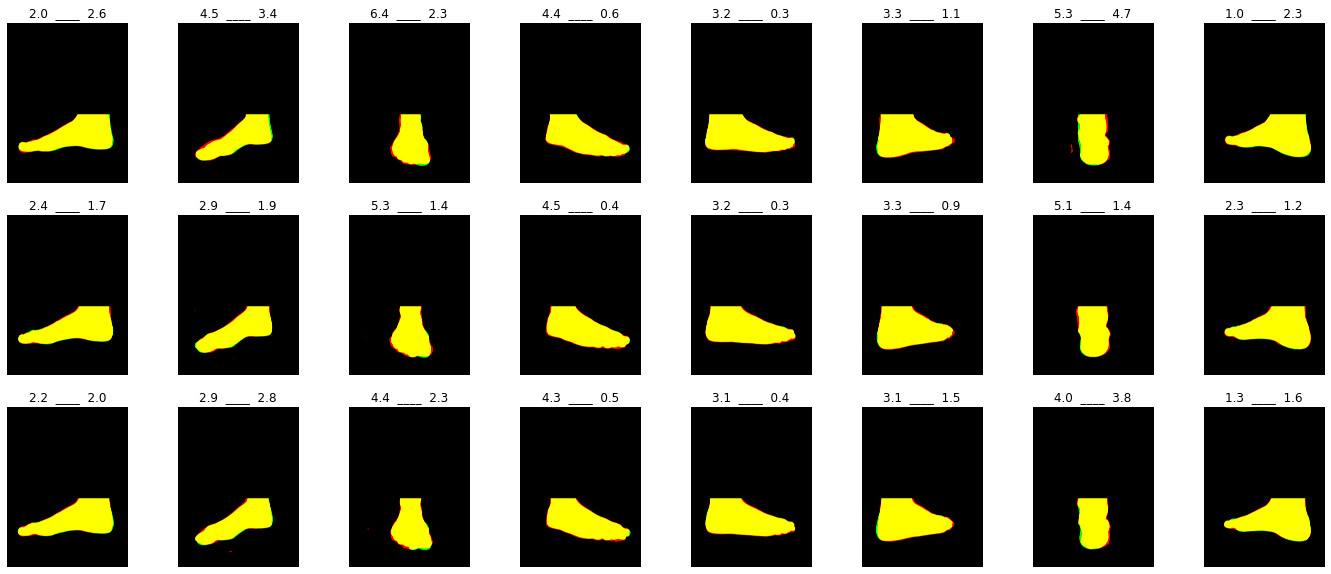

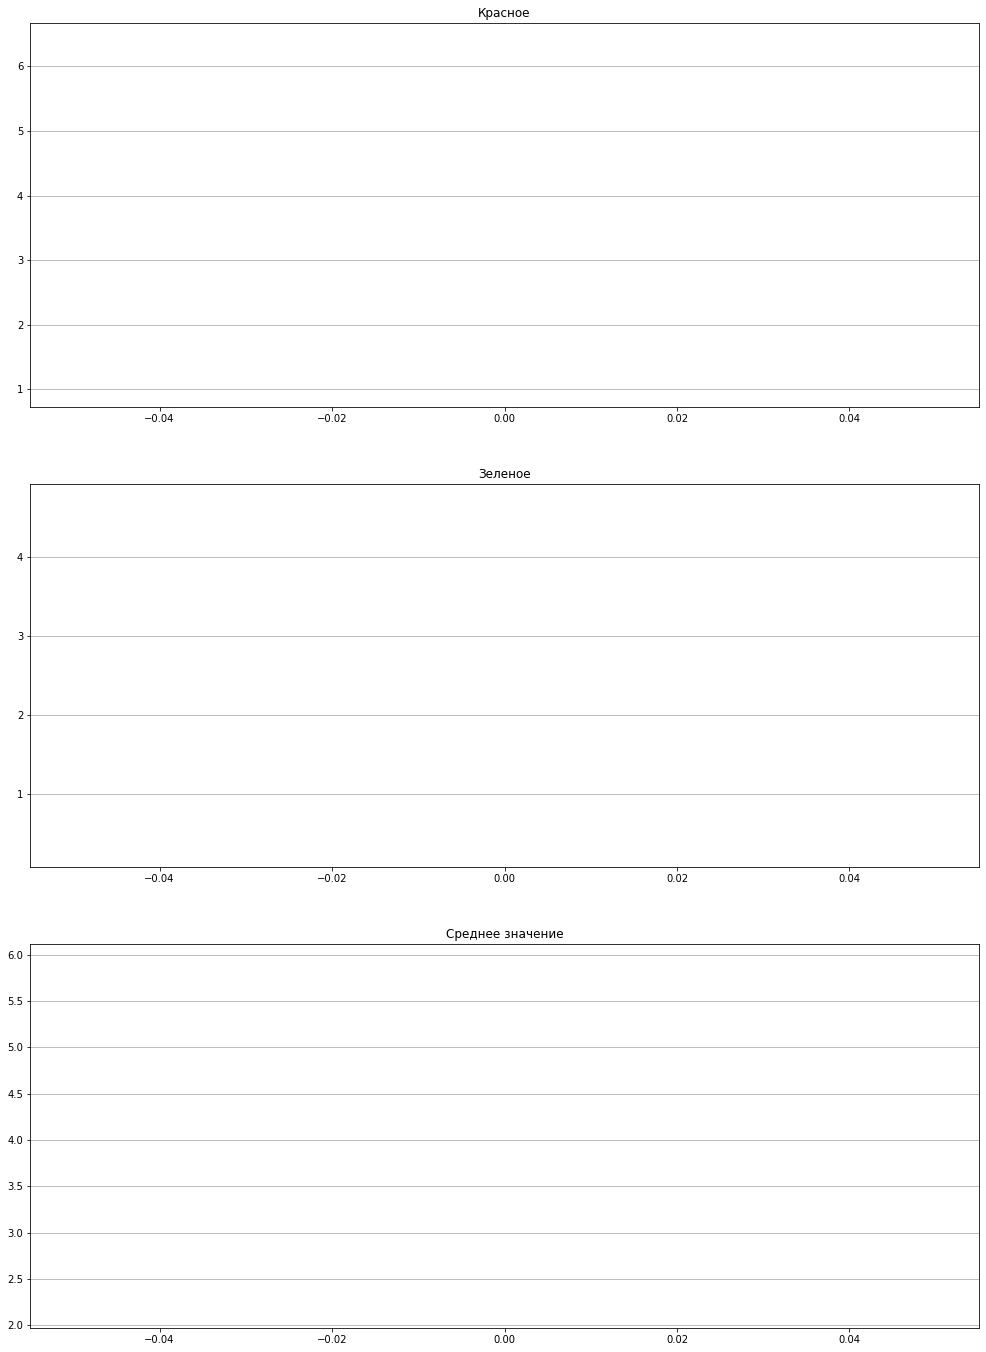

>101, d1[0.366] d2[0.385] g[1.381]
>102, d1[0.371] d2[0.385] g[1.453]
>103, d1[0.369] d2[0.382] g[1.459]
>104, d1[0.367] d2[0.384] g[1.430]
>105, d1[0.368] d2[0.383] g[1.386]
>106, d1[0.365] d2[0.383] g[1.566]
>107, d1[0.367] d2[0.382] g[1.377]
>108, d1[0.369] d2[0.381] g[1.464]
>109, d1[0.368] d2[0.382] g[1.623]
>110, d1[0.360] d2[0.384] g[1.291]
>111, d1[0.382] d2[0.381] g[1.445]
>112, d1[0.363] d2[0.383] g[1.675]
>113, d1[0.371] d2[0.384] g[1.445]
>114, d1[0.364] d2[0.384] g[1.377]
>115, d1[0.361] d2[0.385] g[1.350]
>116, d1[0.364] d2[0.385] g[1.396]
>117, d1[0.362] d2[0.382] g[1.448]
>118, d1[0.380] d2[0.378] g[1.428]
>119, d1[0.364] d2[0.383] g[1.383]
>120, d1[0.361] d2[0.383] g[1.786]
>121, d1[0.368] d2[0.381] g[1.457]
>122, d1[0.370] d2[0.381] g[1.681]
>123, d1[0.369] d2[0.380] g[1.451]
>124, d1[0.363] d2[0.384] g[1.706]
>125, d1[0.365] d2[0.389] g[1.419]
>126, d1[0.372] d2[0.381] g[1.367]
>127, d1[0.369] d2[0.380] g[1.747]
>128, d1[0.366] d2[0.381] g[1.800]
>129, d1[0.371] d2[0

>200, d1[0.371] d2[0.383] g[1.449]
>Saved: /content/drive/MyDrive/Ступни/8chanel_40sample_new/test/model/M_1.h5


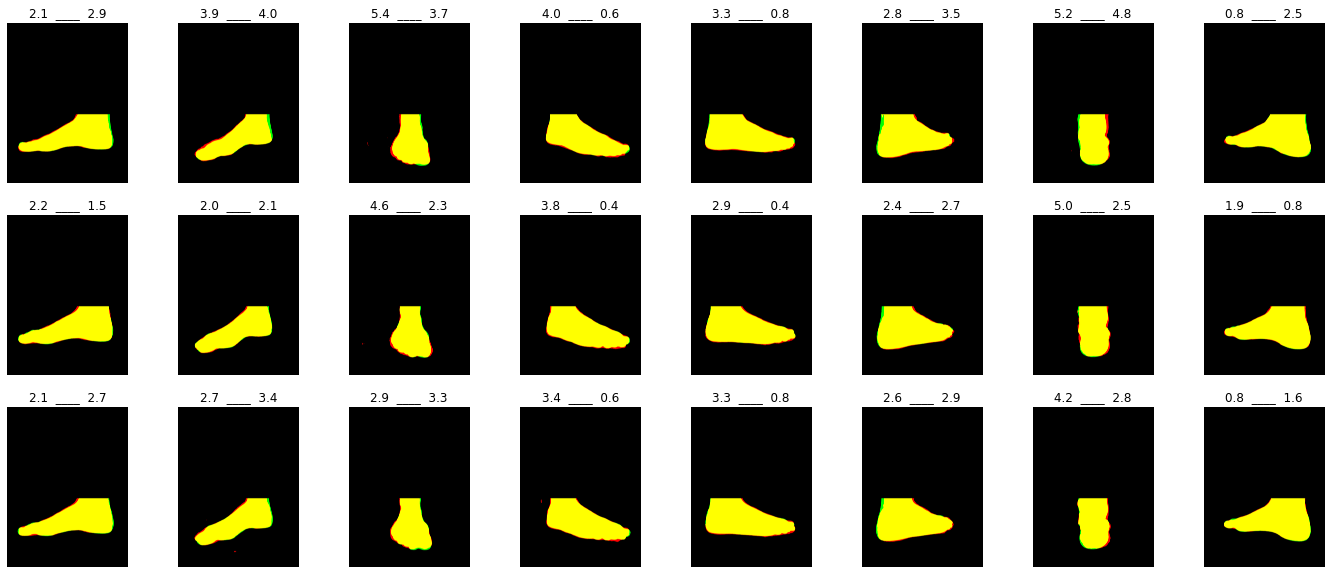

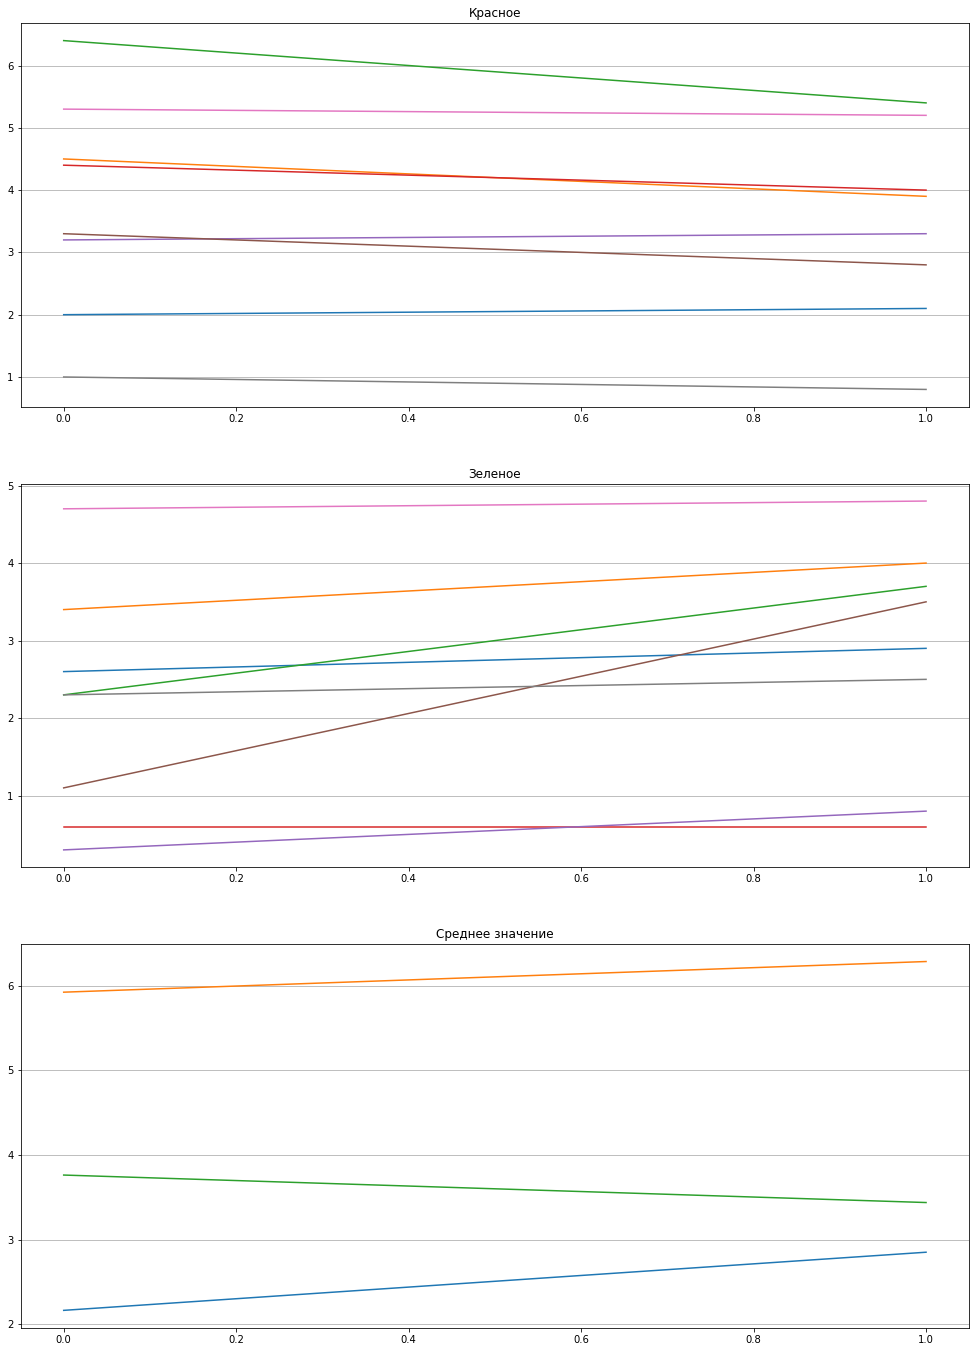

>201, d1[0.373] d2[0.381] g[1.406]
>202, d1[0.358] d2[0.389] g[1.374]
>203, d1[0.367] d2[0.379] g[1.762]
>204, d1[0.374] d2[0.378] g[1.564]
>205, d1[0.362] d2[0.384] g[1.544]
>206, d1[0.368] d2[0.380] g[1.324]
>207, d1[0.372] d2[0.380] g[1.737]
>208, d1[0.388] d2[0.373] g[1.563]
>209, d1[0.372] d2[0.383] g[1.438]
>210, d1[0.364] d2[0.386] g[1.524]
>211, d1[0.362] d2[0.386] g[1.601]
>212, d1[0.353] d2[0.391] g[1.372]
>213, d1[0.372] d2[0.377] g[1.436]
>214, d1[0.360] d2[0.386] g[1.527]
>215, d1[0.367] d2[0.382] g[1.593]
>216, d1[0.394] d2[0.368] g[1.425]
>217, d1[0.359] d2[0.390] g[1.341]
>218, d1[0.376] d2[0.378] g[1.478]
>219, d1[0.359] d2[0.388] g[1.488]
>220, d1[0.361] d2[0.386] g[1.866]
>221, d1[0.364] d2[0.381] g[1.556]
>222, d1[0.370] d2[0.381] g[1.557]
>223, d1[0.360] d2[0.384] g[1.434]
>224, d1[0.362] d2[0.383] g[1.369]
>225, d1[0.366] d2[0.380] g[1.300]
>226, d1[0.367] d2[0.379] g[1.355]
>227, d1[0.367] d2[0.381] g[1.373]
>228, d1[0.355] d2[0.387] g[1.406]
>229, d1[0.367] d2[0

>300, d1[0.359] d2[0.383] g[1.540]
>Saved: /content/drive/MyDrive/Ступни/8chanel_40sample_new/test/model/M_2.h5


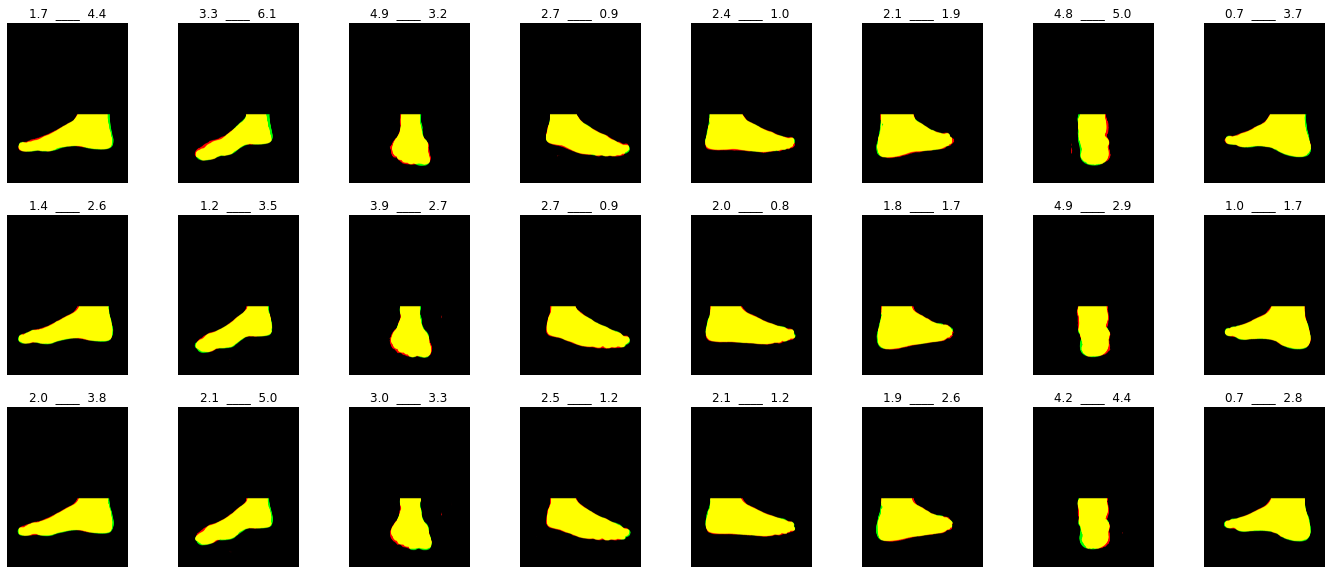

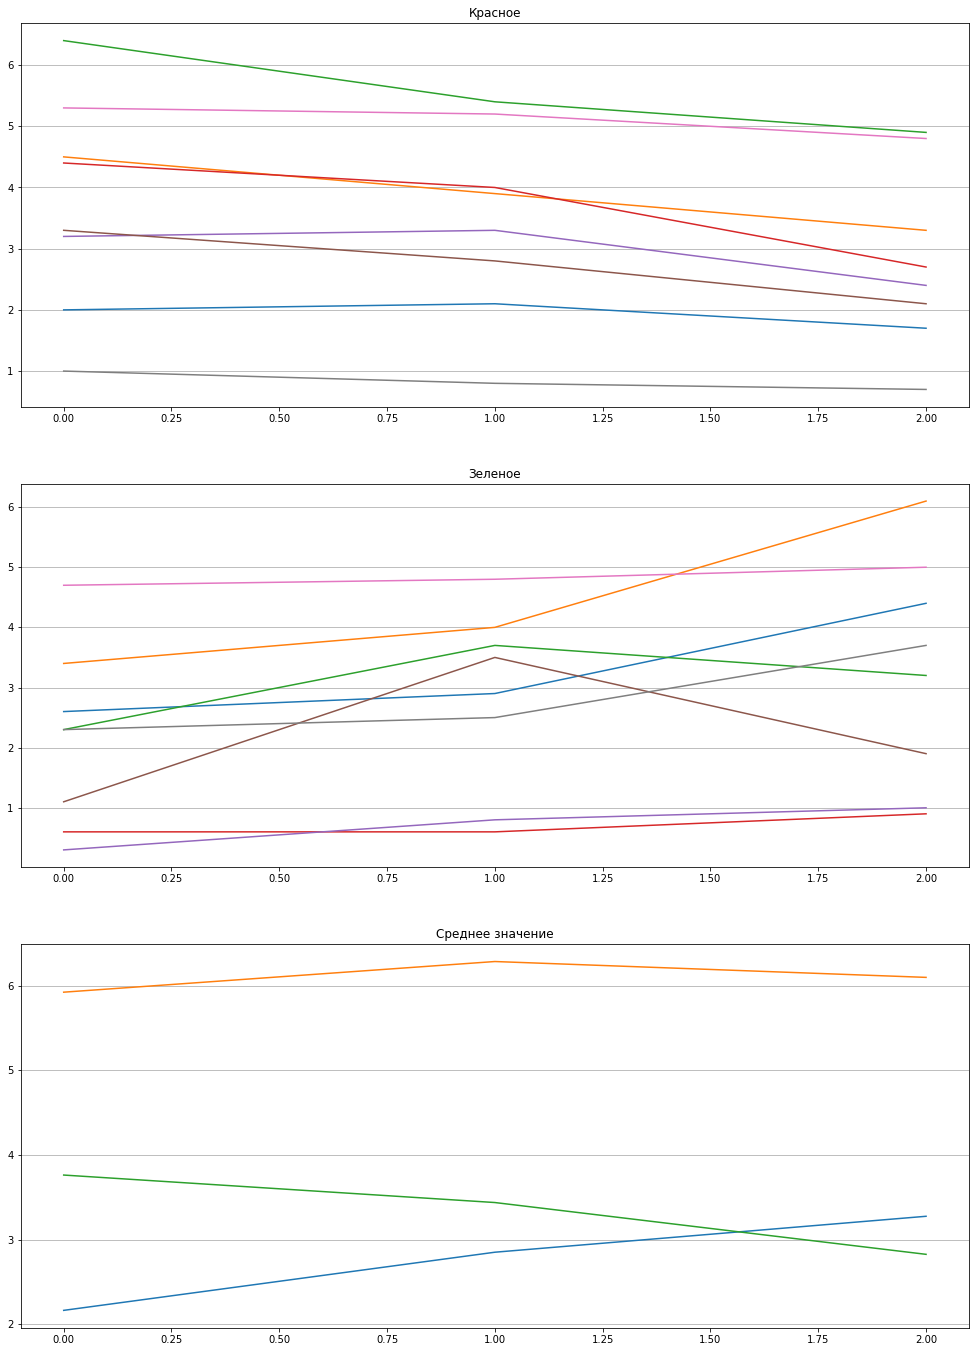

>301, d1[0.372] d2[0.373] g[1.273]
>302, d1[0.373] d2[0.376] g[1.535]
>303, d1[0.379] d2[0.373] g[1.422]
>304, d1[0.367] d2[0.381] g[1.362]
>305, d1[0.399] d2[0.361] g[1.699]
>306, d1[0.356] d2[0.394] g[1.369]
>307, d1[0.351] d2[0.388] g[1.388]
>308, d1[0.380] d2[0.369] g[1.653]
>309, d1[0.351] d2[0.393] g[1.178]
>310, d1[0.361] d2[0.386] g[1.522]
>311, d1[0.359] d2[0.384] g[1.394]
>312, d1[0.342] d2[0.397] g[1.325]
>313, d1[0.349] d2[0.388] g[1.468]
>314, d1[0.369] d2[0.373] g[1.467]
>315, d1[0.390] d2[0.363] g[1.394]
>316, d1[0.394] d2[0.365] g[1.725]
>317, d1[0.349] d2[0.395] g[1.320]
>318, d1[0.363] d2[0.379] g[1.704]
>319, d1[0.358] d2[0.386] g[1.383]
>320, d1[0.378] d2[0.372] g[1.453]
>321, d1[0.342] d2[0.475] g[4.326]
>322, d1[1.783] d2[0.344] g[2.006]
>323, d1[0.710] d2[0.519] g[1.195]
>324, d1[0.332] d2[0.482] g[1.357]
>325, d1[0.319] d2[0.448] g[1.424]
>326, d1[0.331] d2[0.435] g[1.297]
>327, d1[0.359] d2[0.406] g[1.420]
>328, d1[0.374] d2[0.398] g[1.417]
>329, d1[0.360] d2[0

>400, d1[0.363] d2[0.388] g[1.521]
>Saved: /content/drive/MyDrive/Ступни/8chanel_40sample_new/test/model/M_3.h5


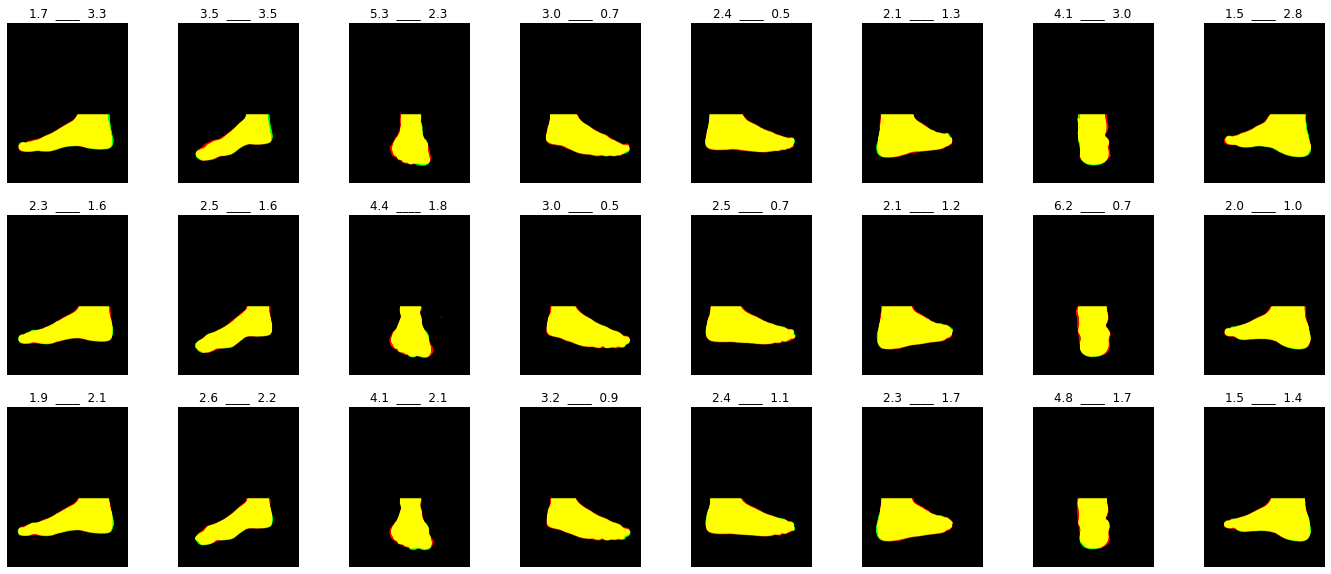

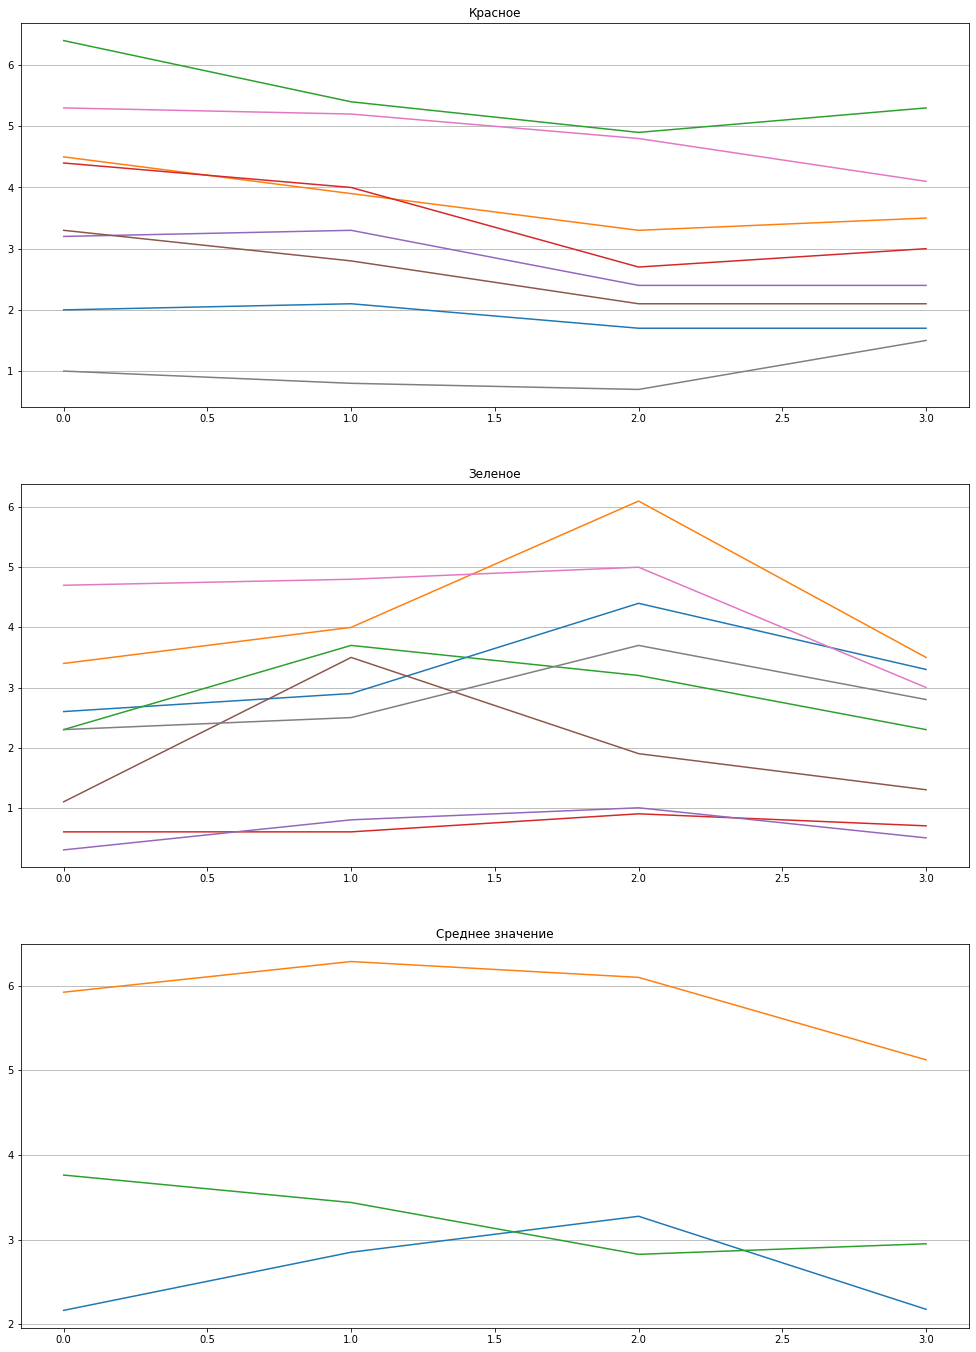

>401, d1[0.372] d2[0.379] g[1.417]
>402, d1[0.356] d2[0.391] g[1.449]
>403, d1[0.356] d2[0.388] g[1.385]
>404, d1[0.345] d2[0.398] g[1.417]
>405, d1[0.428] d2[0.341] g[1.577]
>406, d1[0.382] d2[0.380] g[1.491]
>407, d1[0.349] d2[0.401] g[1.429]
>408, d1[0.336] d2[0.405] g[1.410]
>409, d1[0.353] d2[0.391] g[1.399]
>410, d1[0.389] d2[0.364] g[1.472]
>411, d1[0.384] d2[0.372] g[1.325]
>412, d1[0.360] d2[0.391] g[1.307]
>413, d1[0.348] d2[0.396] g[1.279]
>414, d1[0.369] d2[0.378] g[1.419]
>415, d1[0.353] d2[0.393] g[1.546]
>416, d1[0.369] d2[0.378] g[1.378]
>417, d1[0.378] d2[0.373] g[1.472]
>418, d1[0.396] d2[0.364] g[1.639]
>419, d1[0.355] d2[0.396] g[1.523]
>420, d1[0.366] d2[0.380] g[1.837]
>421, d1[0.372] d2[0.378] g[1.388]
>422, d1[0.375] d2[0.377] g[1.328]
>423, d1[0.354] d2[0.395] g[1.490]
>424, d1[0.346] d2[0.395] g[1.362]
>425, d1[0.337] d2[0.405] g[1.350]
>426, d1[0.376] d2[0.369] g[1.581]
>427, d1[0.375] d2[0.375] g[1.538]
>428, d1[0.349] d2[0.396] g[1.366]
>429, d1[0.358] d2[0

>500, d1[0.370] d2[0.378] g[1.423]
>Saved: /content/drive/MyDrive/Ступни/8chanel_40sample_new/test/model/M_4.h5


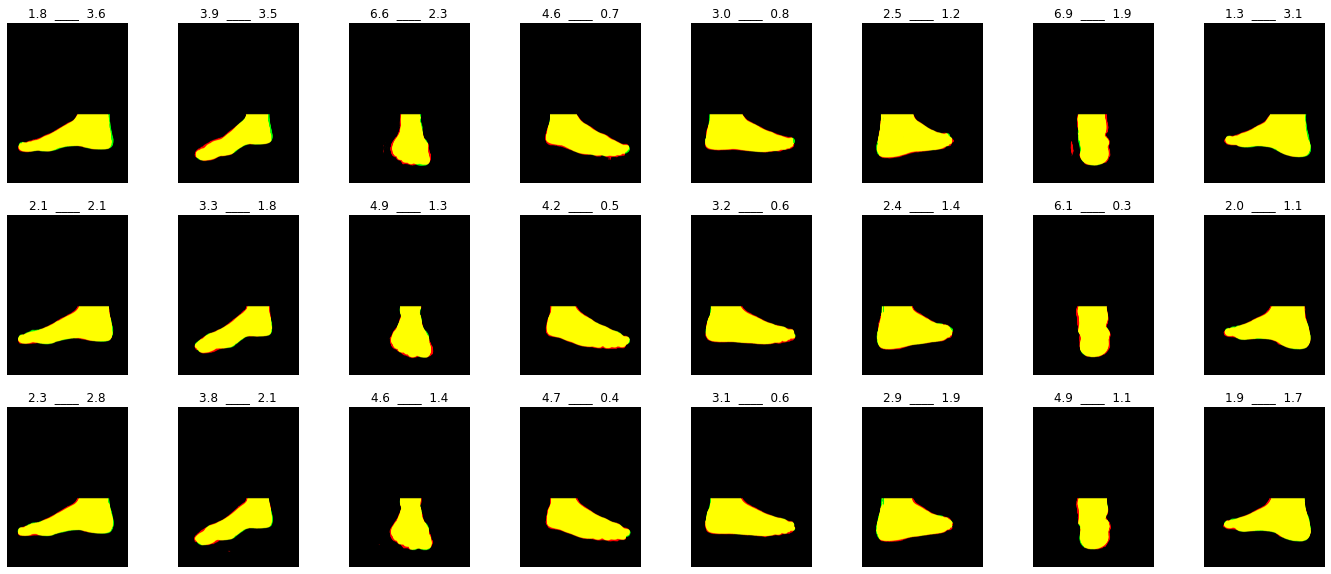

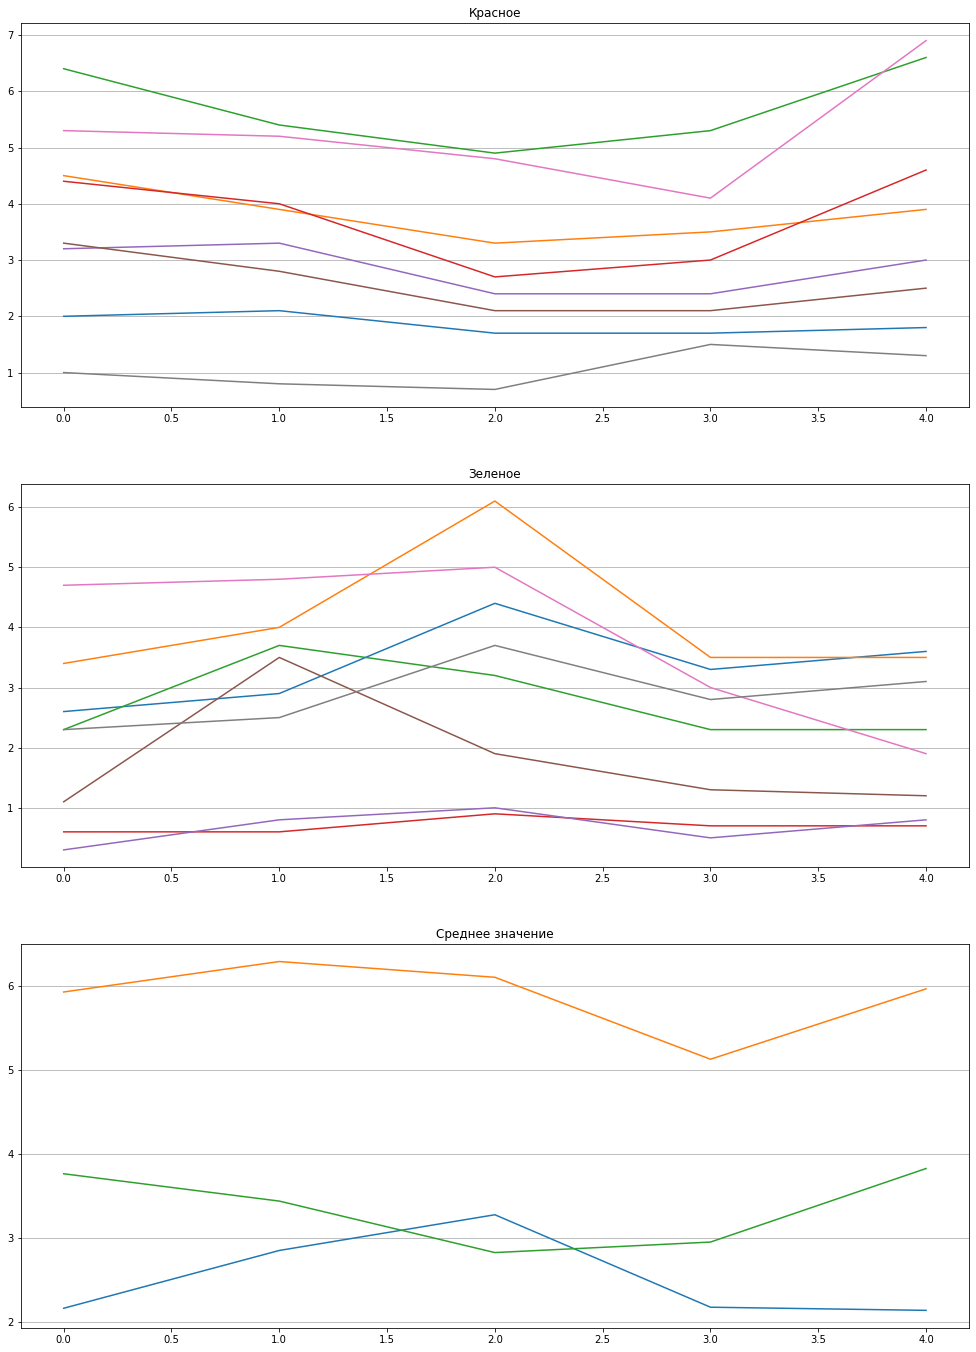

>501, d1[0.360] d2[0.384] g[1.321]
>502, d1[0.328] d2[0.414] g[1.270]
>503, d1[0.373] d2[0.368] g[1.404]
>504, d1[0.350] d2[0.397] g[1.404]
>505, d1[0.374] d2[0.369] g[1.521]
>506, d1[0.340] d2[0.402] g[1.286]
>507, d1[0.353] d2[0.385] g[1.422]
>508, d1[0.370] d2[0.371] g[1.402]
>509, d1[0.343] d2[0.398] g[1.426]
>510, d1[0.380] d2[0.362] g[1.547]
>511, d1[0.356] d2[0.390] g[1.389]
>512, d1[0.368] d2[0.374] g[1.450]
>513, d1[0.365] d2[0.378] g[1.494]
>514, d1[0.338] d2[0.401] g[1.216]
>515, d1[0.340] d2[0.394] g[1.359]
>516, d1[0.405] d2[0.345] g[1.501]
>517, d1[0.390] d2[0.361] g[1.456]
>518, d1[0.365] d2[0.379] g[1.298]
>519, d1[0.378] d2[0.366] g[1.358]
>520, d1[0.371] d2[0.374] g[1.546]
>521, d1[0.326] d2[0.415] g[1.179]
>522, d1[0.371] d2[0.370] g[1.385]
>523, d1[0.362] d2[0.384] g[1.357]
>524, d1[0.341] d2[0.398] g[1.314]
>525, d1[0.376] d2[0.367] g[1.412]
>526, d1[0.351] d2[0.393] g[1.148]
>527, d1[0.338] d2[0.399] g[1.325]
>528, d1[0.347] d2[0.387] g[1.327]
>529, d1[0.400] d2[0

>600, d1[0.357] d2[0.387] g[1.292]
>Saved: /content/drive/MyDrive/Ступни/8chanel_40sample_new/test/model/M_5.h5


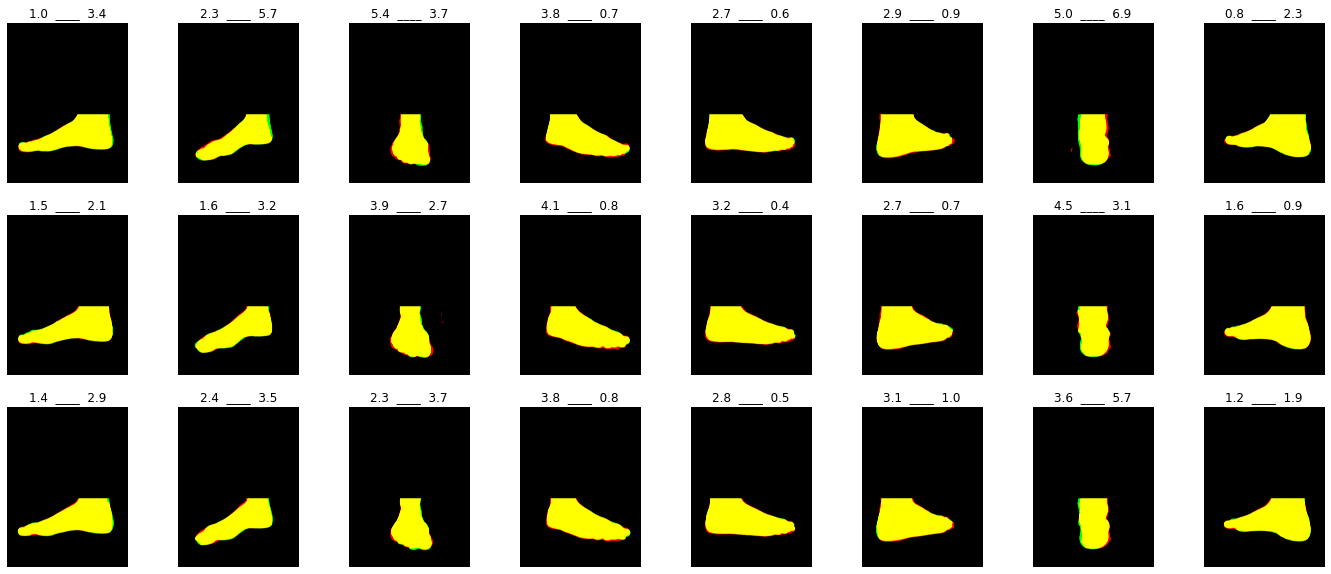

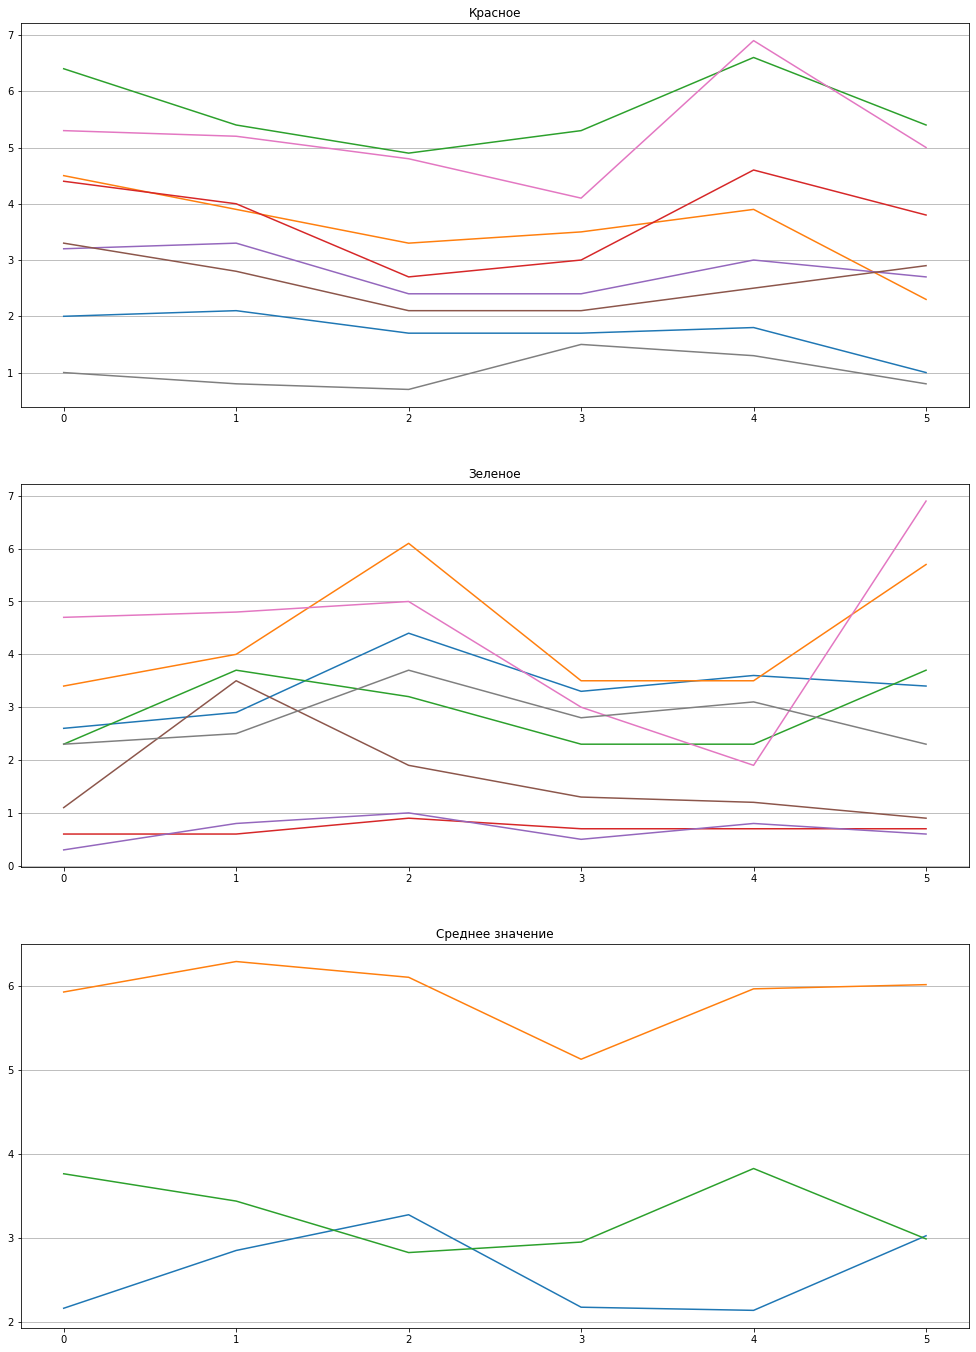

>601, d1[0.349] d2[0.391] g[1.331]
>602, d1[0.427] d2[0.327] g[1.680]
>603, d1[0.410] d2[0.354] g[1.496]
>604, d1[0.397] d2[0.361] g[1.648]
>605, d1[0.343] d2[0.406] g[1.367]
>606, d1[0.350] d2[0.388] g[1.392]
>607, d1[0.317] d2[0.427] g[1.151]
>608, d1[0.333] d2[0.401] g[1.357]
>609, d1[0.413] d2[0.337] g[1.656]
>610, d1[0.355] d2[0.399] g[1.335]
>611, d1[0.393] d2[0.352] g[1.435]
>612, d1[0.333] d2[0.417] g[1.228]
>613, d1[0.319] d2[0.415] g[1.652]
>614, d1[0.323] d2[0.411] g[1.432]
>615, d1[0.366] d2[0.372] g[1.362]
>616, d1[0.369] d2[0.377] g[1.334]
>617, d1[0.362] d2[0.381] g[1.648]
>618, d1[0.386] d2[0.359] g[1.541]
>619, d1[0.341] d2[0.401] g[1.533]
>620, d1[0.356] d2[0.381] g[1.397]
>621, d1[0.368] d2[0.376] g[1.783]
>622, d1[0.410] d2[0.343] g[1.744]
>623, d1[0.344] d2[0.409] g[1.318]
>624, d1[0.376] d2[0.365] g[1.527]
>625, d1[0.353] d2[0.392] g[1.262]
>626, d1[0.356] d2[0.384] g[1.556]
>627, d1[0.321] d2[0.416] g[1.340]
>628, d1[0.387] d2[0.356] g[1.538]
>629, d1[0.331] d2[0

>700, d1[0.349] d2[0.387] g[1.413]
>Saved: /content/drive/MyDrive/Ступни/8chanel_40sample_new/test/model/M_6.h5


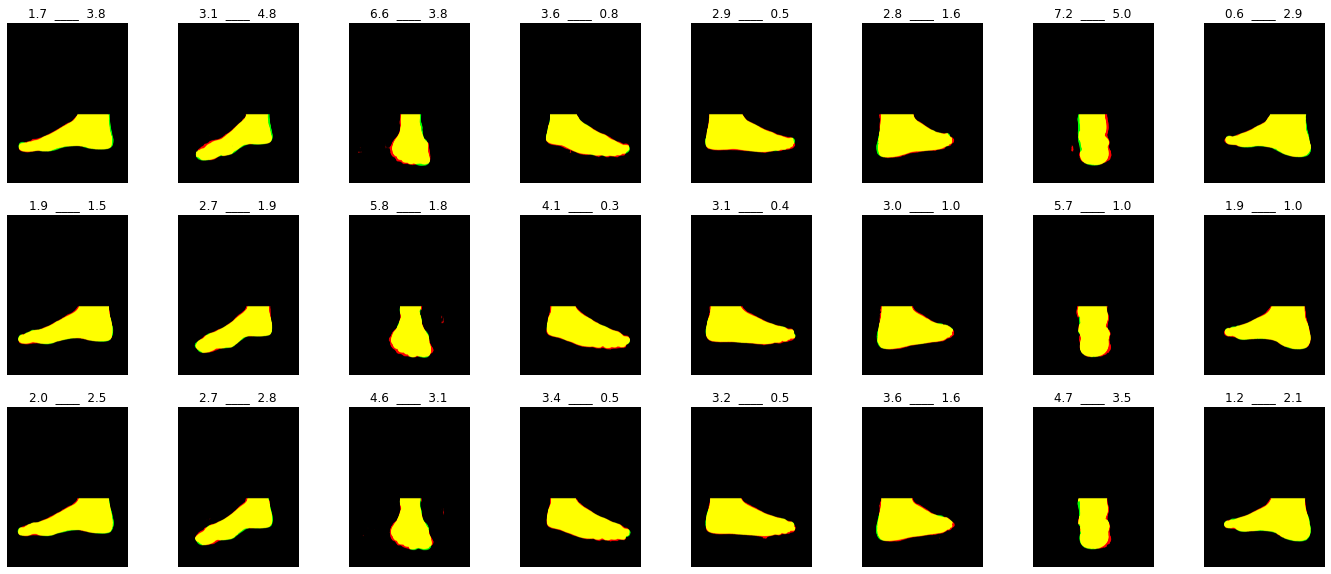

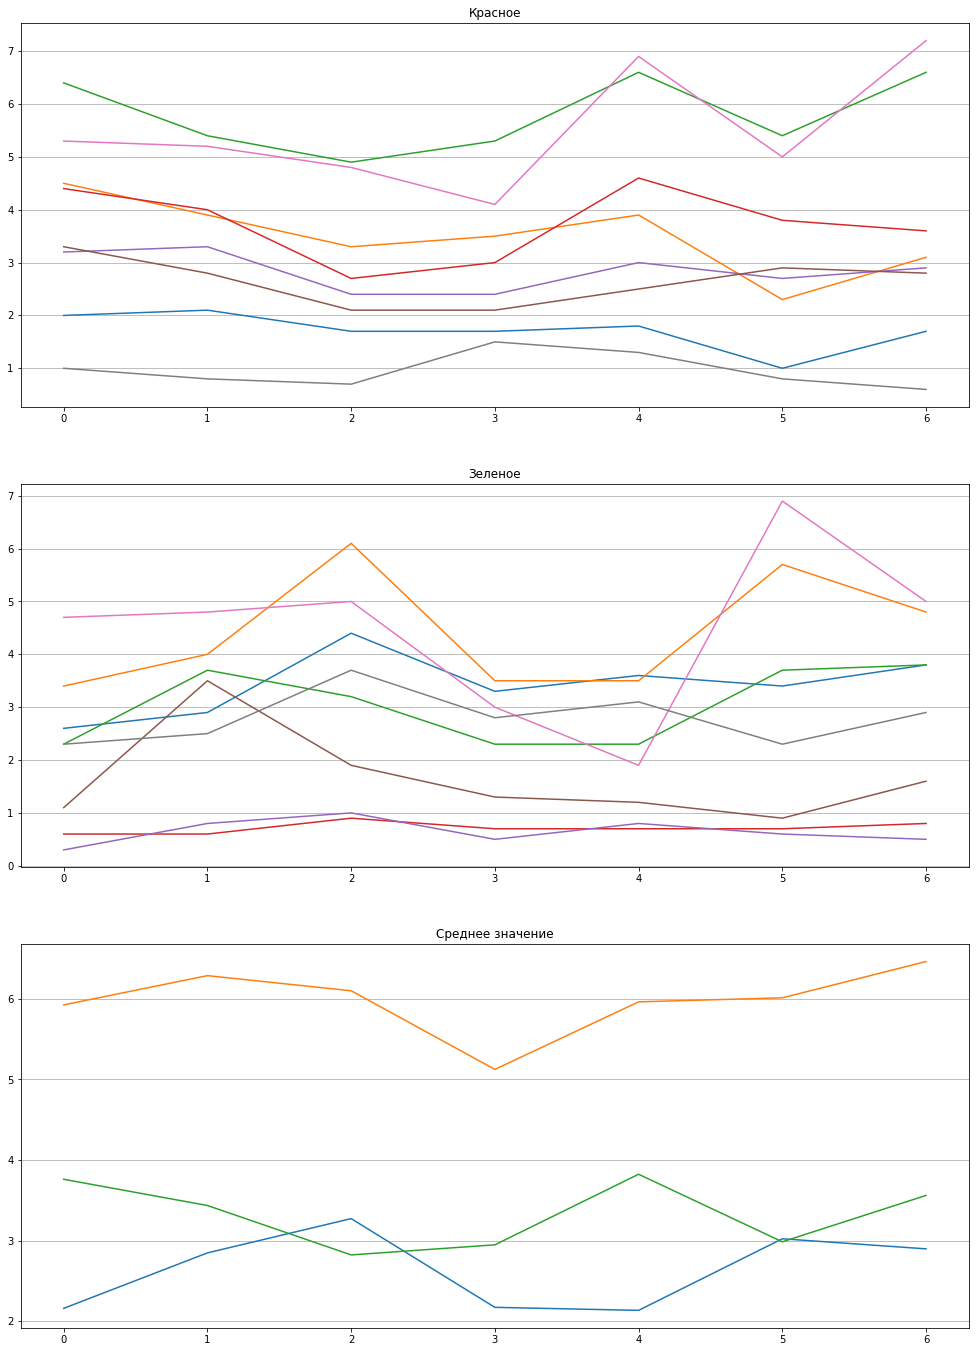

>701, d1[0.429] d2[0.327] g[1.711]
>702, d1[0.358] d2[0.396] g[1.335]
>703, d1[0.337] d2[0.401] g[1.509]
>704, d1[0.322] d2[0.417] g[1.464]
>705, d1[0.367] d2[0.369] g[1.354]
>706, d1[0.316] d2[0.429] g[1.220]
>707, d1[0.377] d2[0.360] g[1.286]
>708, d1[0.363] d2[0.382] g[1.355]
>709, d1[0.325] d2[0.416] g[1.366]
>710, d1[0.378] d2[0.360] g[1.388]
>711, d1[0.463] d2[0.303] g[1.587]
>712, d1[0.368] d2[0.389] g[1.384]
>713, d1[0.353] d2[0.388] g[1.392]
>714, d1[0.332] d2[0.407] g[1.371]
>715, d1[0.380] d2[0.361] g[1.366]
>716, d1[0.316] d2[0.433] g[1.070]
>717, d1[0.364] d2[0.369] g[1.327]
>718, d1[0.409] d2[0.341] g[1.578]
>719, d1[0.362] d2[0.387] g[1.676]
>720, d1[0.324] d2[0.416] g[1.283]
>721, d1[0.420] d2[0.325] g[1.806]
>722, d1[0.344] d2[0.415] g[1.230]
>723, d1[0.367] d2[0.374] g[1.330]
>724, d1[0.366] d2[0.381] g[1.508]
>725, d1[0.343] d2[0.396] g[1.295]
>726, d1[0.348] d2[0.387] g[1.309]
>727, d1[0.346] d2[0.391] g[1.332]
>728, d1[0.344] d2[0.398] g[1.429]
>729, d1[0.344] d2[0

>800, d1[0.352] d2[0.380] g[1.335]
>Saved: /content/drive/MyDrive/Ступни/8chanel_40sample_new/test/model/M_7.h5


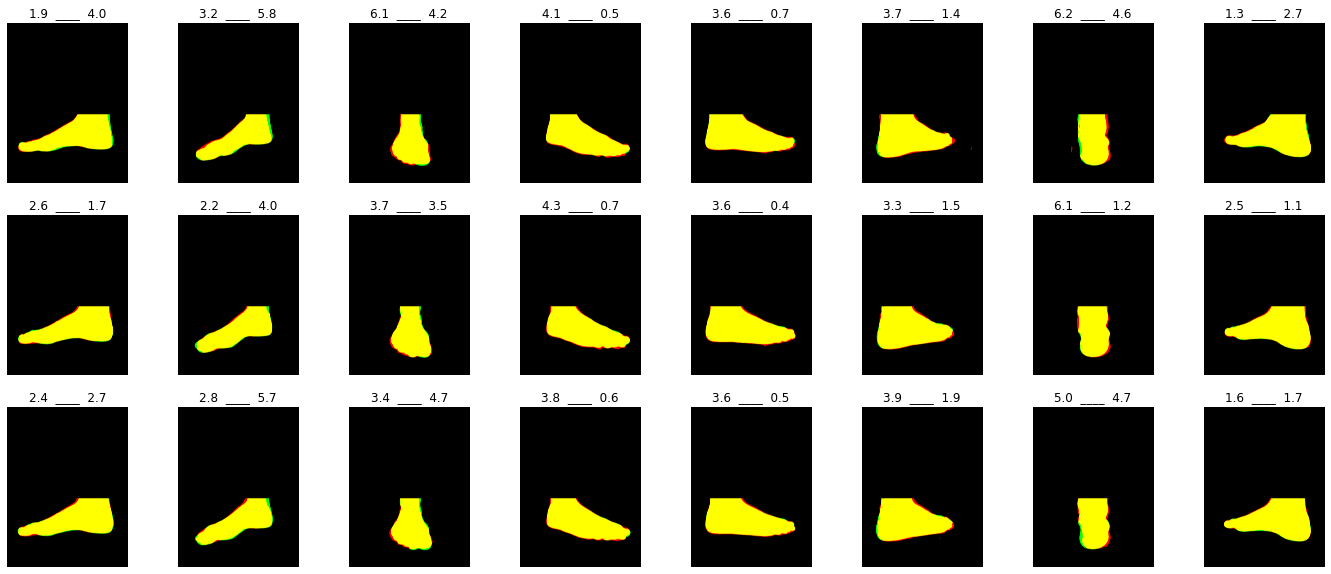

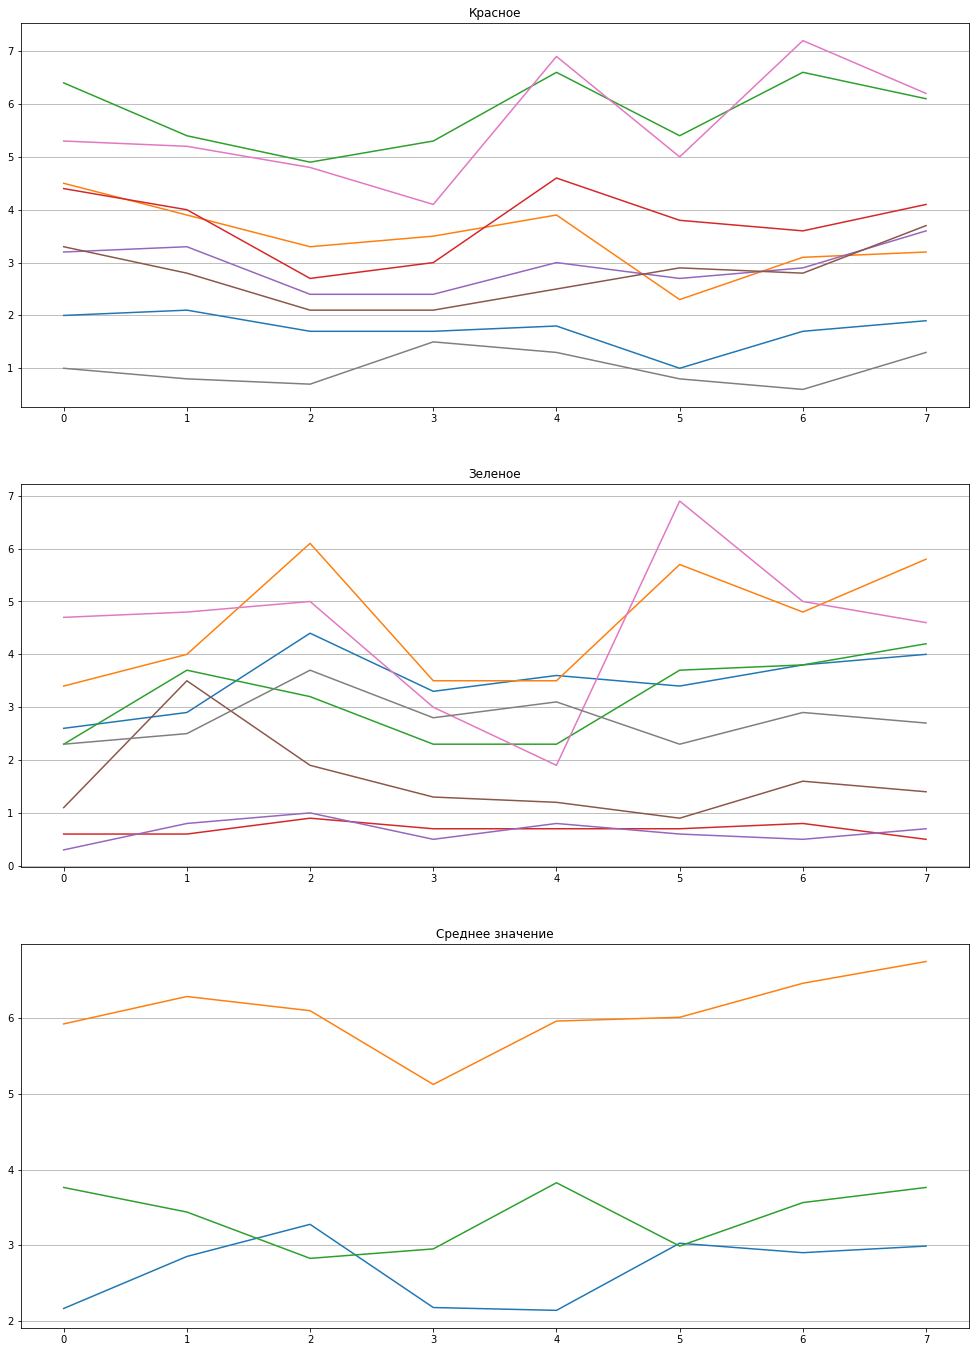

>801, d1[0.366] d2[0.373] g[1.304]
>802, d1[0.341] d2[0.401] g[1.303]
>803, d1[0.349] d2[0.389] g[1.255]
>804, d1[0.354] d2[0.385] g[1.414]
>805, d1[0.374] d2[0.361] g[1.485]
>806, d1[0.383] d2[0.359] g[1.510]
>807, d1[0.375] d2[0.366] g[1.407]
>808, d1[0.370] d2[0.372] g[1.423]
>809, d1[0.342] d2[0.398] g[1.221]
>810, d1[0.312] d2[0.428] g[1.214]
>811, d1[0.337] d2[0.389] g[1.335]
>812, d1[0.370] d2[0.372] g[1.405]
>813, d1[0.375] d2[0.365] g[1.533]
>814, d1[0.451] d2[0.310] g[1.734]
>815, d1[0.357] d2[0.402] g[1.377]
>816, d1[0.375] d2[0.362] g[1.314]
>817, d1[0.346] d2[0.397] g[1.703]
>818, d1[0.361] d2[0.377] g[1.560]
>819, d1[0.401] d2[0.347] g[1.716]
>820, d1[0.336] d2[0.412] g[1.424]
>821, d1[0.310] d2[0.424] g[1.224]
>822, d1[0.344] d2[0.391] g[1.321]
>823, d1[0.352] d2[0.385] g[1.353]
>824, d1[0.350] d2[0.388] g[1.307]
>825, d1[0.324] d2[0.415] g[1.520]
>826, d1[0.359] d2[0.377] g[1.342]
>827, d1[0.421] d2[0.332] g[1.618]
>828, d1[0.345] d2[0.403] g[1.429]
>829, d1[0.358] d2[0

>900, d1[0.369] d2[0.375] g[1.487]
>Saved: /content/drive/MyDrive/Ступни/8chanel_40sample_new/test/model/M_8.h5


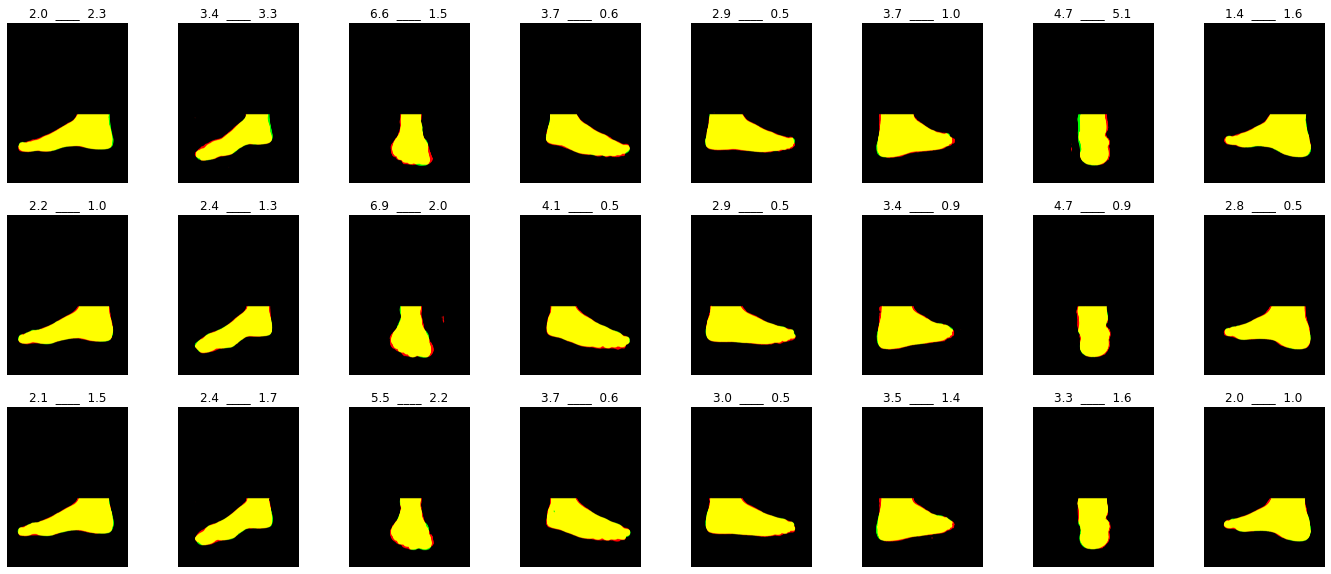

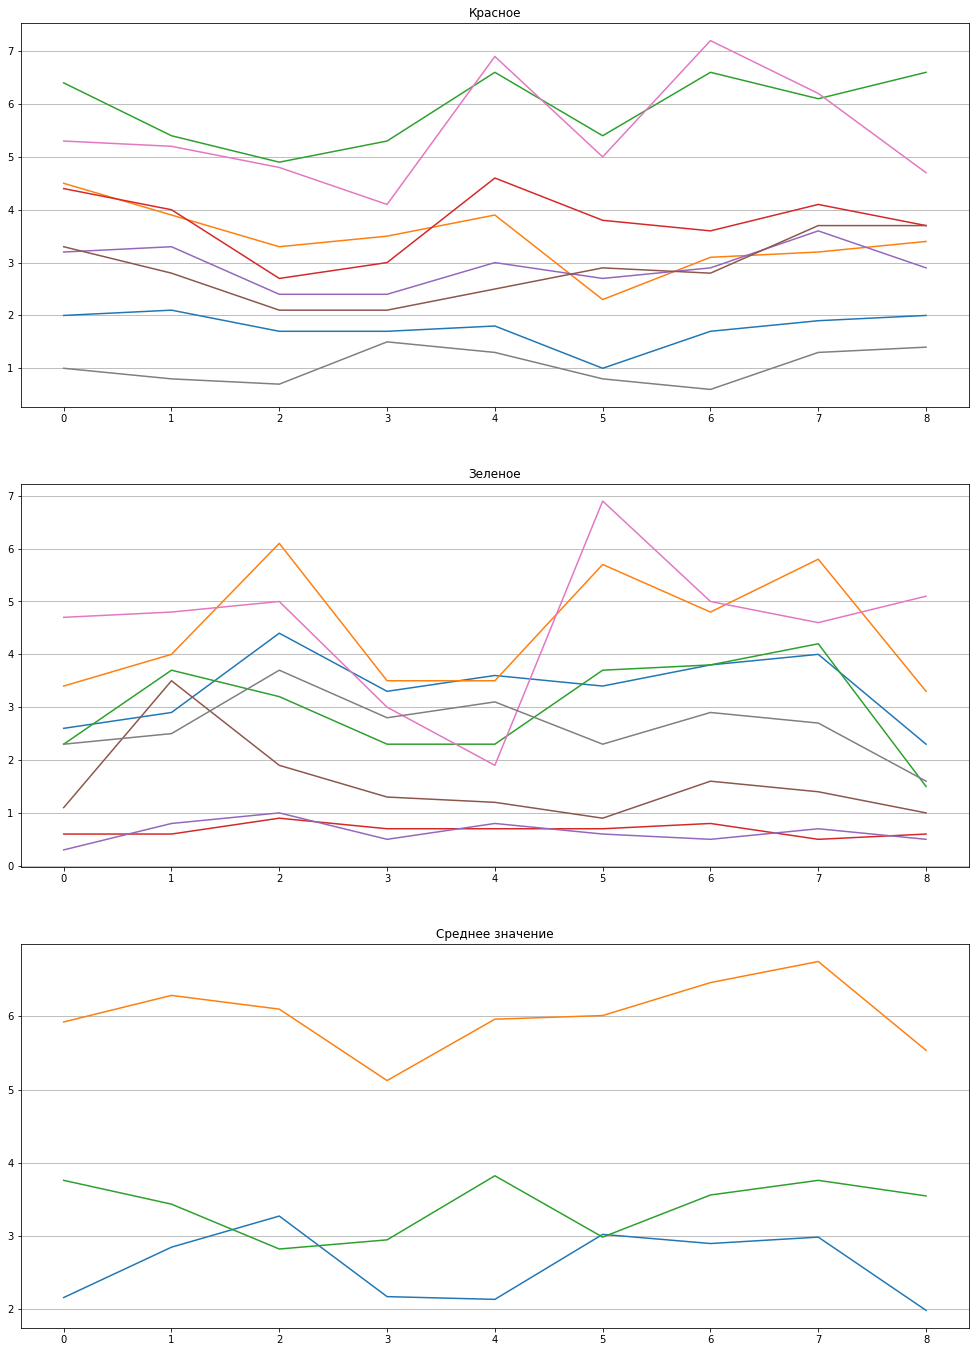

>901, d1[0.450] d2[0.309] g[1.739]
>902, d1[0.346] d2[0.411] g[1.259]
>903, d1[0.344] d2[0.388] g[1.660]
>904, d1[0.402] d2[0.340] g[1.388]
>905, d1[0.335] d2[0.416] g[1.427]
>906, d1[0.343] d2[0.392] g[1.414]
>907, d1[0.321] d2[0.421] g[1.234]
>908, d1[0.345] d2[0.384] g[1.334]
>909, d1[0.381] d2[0.356] g[1.365]
>910, d1[0.356] d2[0.385] g[1.348]
>911, d1[0.363] d2[0.370] g[1.516]
>912, d1[0.310] d2[0.435] g[1.203]
>913, d1[0.338] d2[0.389] g[1.314]
>914, d1[0.318] d2[0.420] g[1.224]
>915, d1[0.354] d2[0.376] g[1.327]
>916, d1[0.364] d2[0.372] g[1.230]
>917, d1[0.330] d2[0.407] g[1.179]
>918, d1[0.438] d2[0.311] g[1.565]
>919, d1[0.371] d2[0.383] g[1.303]
>920, d1[0.324] d2[0.416] g[1.381]
>921, d1[0.319] d2[0.413] g[1.399]
>922, d1[0.434] d2[0.312] g[1.449]
>923, d1[0.390] d2[0.359] g[1.385]
>924, d1[0.328] d2[0.415] g[1.345]
>925, d1[0.372] d2[0.358] g[1.366]
>926, d1[0.347] d2[0.396] g[1.178]
>927, d1[0.377] d2[0.358] g[1.507]
>928, d1[0.393] d2[0.346] g[1.495]
>929, d1[0.361] d2[0

>1000, d1[0.327] d2[0.411] g[1.412]
>Saved: /content/drive/MyDrive/Ступни/8chanel_40sample_new/test/model/M_9.h5


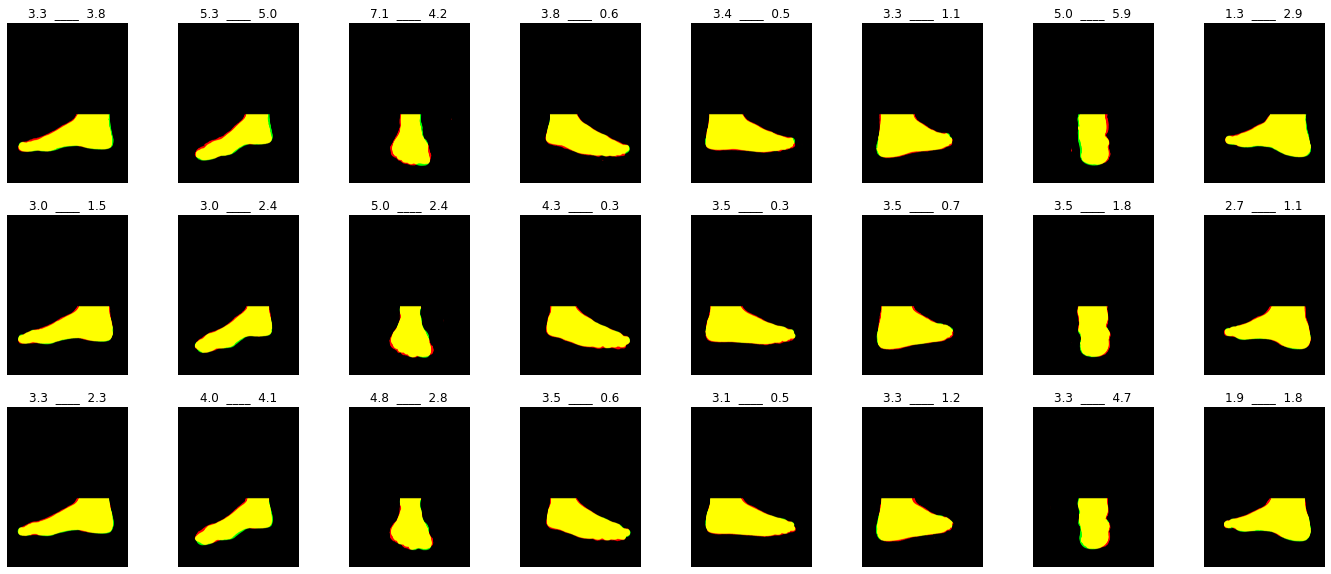

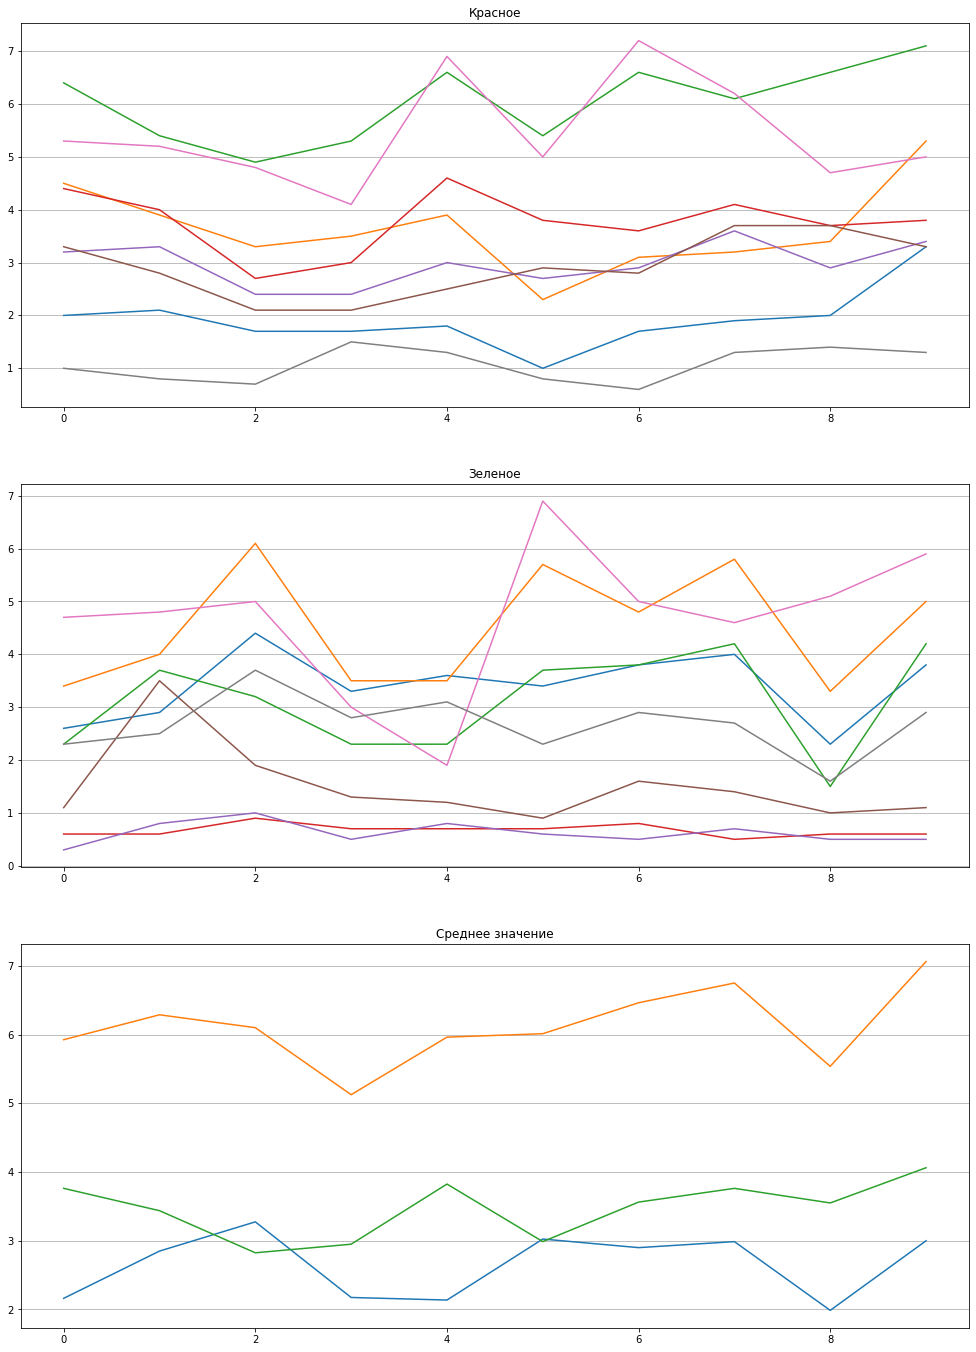

In [ ]:
n_epochs=2
VAL, val, val_red, val_green = [], [], [], []
print(f'     lr={lr}    stddev={stddev}')
rand_index = randint(0,len_data, len_data)
image_shape = [SIZE, SIZE, CHANEL]

#g_model = define_generator(image_shape)  # для обучения с нуля
g_model = load_model('/content/drive/MyDrive/Ступни/8chanel_40sample_new/test/model/M__1__.h5') # для до обучения с уже обученной моделью
d_model = define_discriminator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

train(d_model, g_model, gan_model, n_epochs)